# Notebook

In [1]:
from tifffile import imread, imwrite
import numpy as np
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from tqdm import tqdm
import matplotlib.pyplot as plt
import btrack
from btrack.constants import BayesianUpdates
import pandas as pd

import os
import sys
sys.path.append("..")

print(sys.path)

from adccfactory.core import segment_target_cells, track_target_cells, measure_cell_intensities, measure_death_events
from adccfactory.plot import set_size, plot_class, plot_cell_signal

from tensorflow.keras.models import load_model

!pwd

['/home/limozin/Documents/GitHub/ADCCFactory/examples', '/home/limozin/anaconda3/lib/python38.zip', '/home/limozin/anaconda3/lib/python3.8', '/home/limozin/anaconda3/lib/python3.8/lib-dynload', '', '/home/limozin/.local/lib/python3.8/site-packages', '/home/limozin/anaconda3/lib/python3.8/site-packages', '/home/limozin/anaconda3/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg', '/home/limozin/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/home/limozin/.ipython', '..']
/home/limozin/Documents/GitHub/ADCCFactory/examples


In [2]:
stack = imread("movie/example_adcc_movie.tif")
stack = np.moveaxis(stack, 1, -1)
print(f"Shape of the loaded stack: {stack.shape}")

len_movie = stack.shape[0]
shape_x = stack.shape[1]
shape_y = stack.shape[2]
transmission = 0
blue_channel = 2
red_channel = 1
PxToUm = 0.3112

Shape of the loaded stack: (25, 512, 512, 3)


## Segmentation of the target cells

In [3]:
model = StarDist2D(None, name=f'segmentation_tc/stardist_05-07-2022', basedir="../models")
labels = segment_target_cells(stack[:,:,:,[red_channel,blue_channel]],model)

  0%|          | 0/25 [00:00<?, ?it/s]

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.538629, nms_thresh=0.3.


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


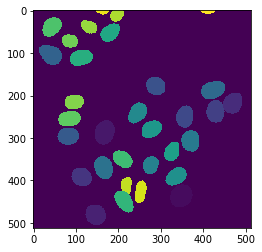

In [4]:
plt.imshow(labels[0])

## Tracking of the target cells

In [5]:
cell_config = '../adccfactory/cell_config.json'
trajectories = track_target_cells(labels,cell_config,PxToUm=PxToUm)
display(trajectories)

[INFO][2022/07/18 02:20:28 PM] Localizing objects from segmentation...
[INFO][2022/07/18 02:20:29 PM] Objects are of type: <class 'dict'>
[INFO][2022/07/18 02:20:29 PM] ...Found 781 objects in 25 frames.
[INFO][2022/07/18 02:20:29 PM] Loaded btrack: /home/limozin/anaconda3/lib/python3.8/site-packages/btrack/libs/libtracker.so
[INFO][2022/07/18 02:20:29 PM] btrack (v0.4.2) library imported
[INFO][2022/07/18 02:20:29 PM] Setting max XYZ search radius to: 100
[INFO][2022/07/18 02:20:29 PM] Starting BayesianTracker session
[INFO][2022/07/18 02:20:29 PM] Loading configuration file: ../adccfactory/cell_config.json
[INFO][2022/07/18 02:20:29 PM] Loading motion model: b'cell_motion'
[INFO][2022/07/18 02:20:29 PM] Setting Bayesian update method to: BayesianUpdates.EXACT
[INFO][2022/07/18 02:20:29 PM] Objects are of type: <class 'list'>
[INFO][2022/07/18 02:20:29 PM] Set volume to ((0, 512), (0, 512), (-100000.0, 100000.0))
[INFO][2022/07/18 02:20:29 PM] Starting tracking... 
[INFO][2022/07/18 0

,TRACK_ID,FRAME,POSITION_Y,POSITION_X,SPOT_ID
0,1.0,0.0,66.998643,29.945590,0
1,1.0,1.0,66.981852,29.989622,1
2,1.0,2.0,67.097458,29.763236,2
3,1.0,3.0,66.995480,29.666060,3
4,1.0,4.0,66.630965,29.645809,4
...,...,...,...,...,...
775,32.0,24.0,74.454928,76.309326,775
776,33.0,5.0,125.765445,154.269259,776
777,34.0,5.0,95.011899,8.399042,777
778,34.0,6.0,95.374247,8.787123,778


## Detection of cell death events

100%|██████████| 32/32 [00:00<00:00, 85489.00it/s]

Minimum frame = 0.0, Maximum frame = 24.0
Filtering tracks that do not start at frame 0.0...
Number of remaining tracks is 32...
Measuring each cell...
(32, 128)


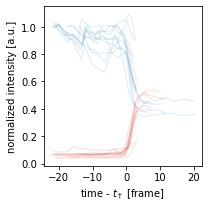

AI death event detection results: 
20 cells do not die during the movie...
12 cells die during the movie...


,TID,X,Y,T,BLUE_INTENSITY,RED_INTENSITY,CLASS,T0
0,1.0,96.226190,215.291270,0.0,2773.633318,153.262388,1,-1.000000
1,1.0,96.367681,215.237315,1.0,2806.874941,148.310996,1,-1.000000
2,1.0,95.640220,215.608798,2.0,2728.545540,147.331760,1,-1.000000
3,1.0,95.327957,215.281106,3.0,2663.439358,151.752714,1,-1.000000
4,1.0,95.262883,214.109783,4.0,2571.352525,148.988202,1,-1.000000
...,...,...,...,...,...,...,...,...
795,32.0,245.491495,243.477521,20.0,2351.925908,171.005663,0,22.221169
796,32.0,245.646775,243.138638,21.0,2351.701746,183.717319,0,22.221169
797,32.0,245.367433,243.409806,22.0,2392.664464,243.226522,0,22.221169
798,32.0,245.470070,242.679577,23.0,2287.199622,273.074563,0,22.221169


In [11]:
models = [load_model("../models/sequential/classifier_0.2.h5"),load_model("../models/sequential/regressor.h5")]
intensity_measurement_radius = 26
df0 = measure_cell_intensities(trajectories, intensity_measurement_radius, stack[:,:,:,blue_channel], stack[:,:,:,red_channel], len_movie, PxToUm=PxToUm)

# Detect death events
df = measure_death_events(df0, models, len_movie, model_signal_length = 128, mode="sequential")
display(df)

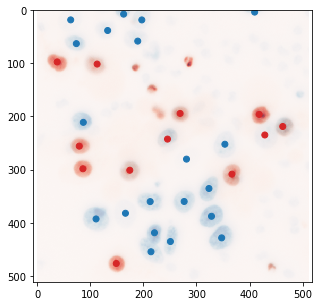

In [12]:
plot_class(df,stack,red_channel=1,blue_channel=2,figsize=(5,5))

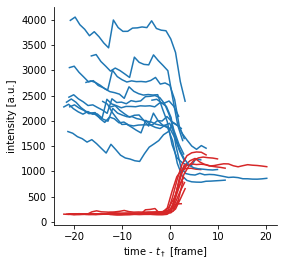

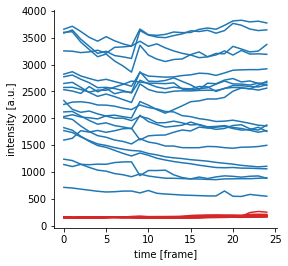

In [13]:
plot_cell_signal(df,population="dead",centered=True)
plot_cell_signal(df,population="alive",centered=True)

Text(0, 0.5, 'intensity [a.u.]')

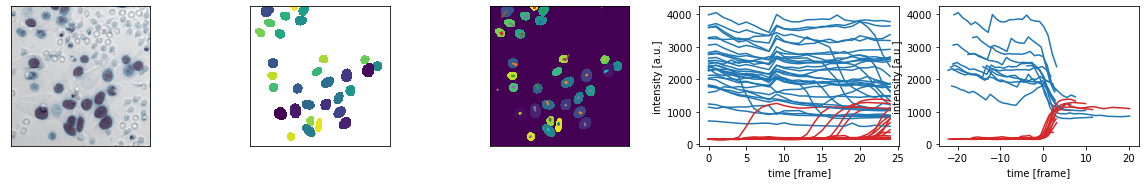

In [14]:
fig,ax = plt.subplots(1,5,figsize=set_size(1500,subplots=(1,5)))

ax[0].imshow(stack[-1,:,:,0],cmap="gray",vmin=19369,vmax=34001)
ax[0].imshow(stack[-1,:,:,2],cmap="Blues",vmin=132,vmax=2561,alpha=0.6)
ax[0].imshow(stack[-1,:,:,2],cmap="Reds",vmin=556,vmax=5916,alpha=0.2)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(np.ma.masked_where((labels[-1]==0.0),labels[-1]),cmap="viridis")
ax[1].set_xticks([])
ax[1].set_yticks([])

#ax[2].imshow(np.ma.masked_where((labels[-1]==0.0),labels[-1]),cmap="viridis")
ax[2].imshow(labels[-1],cmap="viridis")
unique_cells = np.unique(trajectories)
for cell in unique_cells:
    x = trajectories.loc[trajectories["TRACK_ID"]==cell,"POSITION_X"].to_numpy()
    y = trajectories.loc[trajectories["TRACK_ID"]==cell,"POSITION_Y"].to_numpy()
    x /= PxToUm
    y /= PxToUm
    ax[2].plot(x,y)
ax[2].set_xticks([])
ax[2].set_yticks([])

cells = np.unique(df0["TID"].to_numpy())
for cell in cells:
    blue = df0.loc[df0["TID"]==cell,"BLUE_INTENSITY"].to_numpy()
    red = df0.loc[df0["TID"]==cell,"RED_INTENSITY"].to_numpy()
    times = df0.loc[df0["TID"]==cell,"T"].to_numpy()
    ax[3].plot(times, blue, c="tab:blue")
    ax[3].plot(times, red, c="tab:red")
ax[3].set_xlabel('time [frame]')
ax[3].set_ylabel('intensity [a.u.]')

for cell in cells:
    try:
        blue = df.loc[(df["TID"]==cell)&(df["CLASS"]==0.0),"BLUE_INTENSITY"].to_numpy()
        red = df.loc[(df["TID"]==cell)&(df["CLASS"]==0.0),"RED_INTENSITY"].to_numpy()
        death_time = df.loc[(df["TID"]==cell)&(df["CLASS"]==0.0),"T0"].to_numpy()[0]
        times = df.loc[df["TID"]==cell,"T"].to_numpy()
        ax[4].plot(times - death_time, blue, c="tab:blue")
        ax[4].plot(times - death_time, red, c="tab:red")
    except:
        continue
ax[4].set_xlabel('time [frame]')
ax[4].set_ylabel('intensity [a.u.]')

